In [2]:
import os
import h5py
import numpy as np
from torchdeepretina.datas import loadexpt, _loadexpt_h5
from scipy.stats import pearsonr

In [3]:
data_path = os.path.join('/home/melander/salamander/experiments/data/')

In [4]:
import torch
from collections import deque

In [5]:
def get_hs(model, batch_size, device):
    hs = []
    hs.append(torch.zeros(batch_size, *model.h_shapes[0]).to(device))
    hs[0][:,0] = 1
    hs.append(deque([],maxlen=model.seq_len))
    for i in range(model.seq_len):
        hs[1].append(torch.zeros(batch_size, *model.h_shapes[1]).to(device))
    return hs

In [1]:
import sys
import torch.nn as nn
sys.path.insert(0, './kinetic')
from kinetic.models import KineticsChannelModel
from kinetic.evaluation import pearsonr_eval
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import torch
device = torch.device('cuda:2')
model = KineticsChannelModel().to(device)
#checkpoint_path = '/home/xhding/saved_model/channel/epoch_080_loss_-3.33_pearson_0.4375.pth'
#checkpoint_path = '/home/xhding/saved_model/channel/epoch_25_loss_-18.694432266607983_pearson_0.2555771604004841.pth'
#checkpoint_path = '/home/xhding/saved_model/channel/epoch_30_loss_-19.44398377867029_pearson_0.06683283809680479.pth'
checkpoint_path = '/home/xhding/saved_model/channel/epoch_5_loss_0.5841702525201724_pearson_nan.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
class ValidationDataset(Dataset):
    
    def __init__(self, data_path):
        super().__init__()
        data = loadexpt('15-10-07', [0,1,2,3,4], 'naturalscene', 'train',
                        40, 0, data_path=data_path)
        val_size = 30000
        self.X = data.X[-val_size:]
        self.y = data.y[-val_size:]
        self.centers = data.centers
        self.stats = data.stats
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        inpt = torch.from_numpy(self.X[index])
        trgt = torch.from_numpy(self.y[index])
        return (inpt, trgt)

In [12]:
validation_data =  DataLoader(ValidationDataset(data_path), batch_size=512)

In [10]:
loss_fn = nn.PoissonNLLLoss(log_input=False).to(device)

In [15]:
def pearsonr_eval(model, data, n_units, device):
    loss = 0
    hs = get_hs(model, 1, device)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        pearsons = []
        val_pred = []
        val_targ = []
        for x,y in data:
            x = x.to(device)
            out, hs = model(x, hs)
            loss += loss_fn(out.double(), y.to(device))
            val_pred.append(out.detach().cpu().numpy().squeeze())
            val_targ.append(y.detach().numpy().squeeze())
        val_pred = np.stack(val_pred, axis=0)
        val_targ = np.stack(val_targ, axis=0)
        for cell in range(n_units):
            pearsons.append(pearsonr(val_pred[:,cell],val_targ[:,cell])[0])
        loss = loss/30000
        return np.array(pearsons).mean(), val_pred, val_targ, loss
    
def pearsonr_eval_printh(model, data, n_units, intrv, device):
    loss = 0
    hs = get_hs(model, 1, device)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        pearsons = []
        val_pred = []
        val_targ = []
        for idx, (x,y) in enumerate(data):
            x = x.to(device)
            out, hs = model(x, hs)
            loss += loss_fn(out.double(), y.to(device))
            val_pred.append(out.detach().cpu().numpy().squeeze())
            val_targ.append(y.detach().numpy().squeeze())
            if idx % intrv == 0:
                print(idx, hs[0].min(), hs[0].max())
        val_pred = np.stack(val_pred, axis=0)
        val_targ = np.stack(val_targ, axis=0)
        for cell in range(n_units):
            pearsons.append(pearsonr(val_pred[:,cell],val_targ[:,cell])[0])
        loss = loss/30000
        return np.array(pearsons).mean(), val_pred, val_targ, loss
    
def pearsonr_eval_reset(model, data, reset_int, data_len, n_units, device):
    loss = 0
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        pearsons = []
        val_pred = []
        val_targ = []
        for idx, (x,y) in enumerate(data):
            if idx % reset_int == 0:
                hs = get_hs(model, 1, device)
            x = x.to(device)
            out, hs = model(x, hs)
            loss += loss_fn(out.double(), y.to(device))
            val_pred.append(out.detach().cpu().numpy().squeeze())
            val_targ.append(y.detach().numpy().squeeze())
        val_pred = np.stack(val_pred, axis=0)
        val_targ = np.stack(val_targ, axis=0)
        for cell in range(n_units):
            pearsons.append(pearsonr(val_pred[:,cell],val_targ[:,cell])[0])
        loss = loss/data_len
        return np.array(pearsons).mean(), val_pred, val_targ, loss

In [7]:
from kinetic.data import BatchRnnSampler
train_dataset = ValidationDataset(data_path)
batch_sampler = BatchRnnSampler(length=len(train_dataset), batch_size=512, seq_len=8)
validation_data_2 = DataLoader(dataset=train_dataset, batch_sampler=batch_sampler)
def pearsonr_eval_2(model, data, device):
    model.eval()
    epoch_loss = 0
    loss_array = []
    hs = get_hs(model, 512, device)
    with torch.no_grad():
        for idx,(x,y) in enumerate(data):
            x = x.to(device)
            y = y.double().to(device)
            out, hs = model(x, hs)
            loss = loss_fn(out.double(), y)
            loss_array.append(loss.detach().cpu().numpy())
            epoch_loss += loss
            if idx % 8 == 0:
                h_0 = []
                h_0.append(hs[0].detach())
                h_0.append(deque([h.detach() for h in hs[1]], maxlen=model.seq_len))
            if idx % 8 == 7:
                hs[0] = h_0[0].detach()
                hs[1] = deque([h.detach() for h in h_0[1]], maxlen=model.seq_len)
        epoch_loss = epoch_loss / len(train_dataset) * 512
        loss_array = np.array(loss_array)
    return epoch_loss.detach().cpu().numpy(), loss_array

def pearsonr_eval_3(model, data, device, batch_size):
    model.eval()
    epoch_loss = 0
    hs = get_hs(model, batch_size, device)
    with torch.no_grad():
        for idx,(x,y) in enumerate(data):
            x = x.to(device)
            y = y.double().to(device)
            out, hs = model(x, hs)
            loss = loss_fn(out.double(), y)
            epoch_loss += loss
        epoch_loss = epoch_loss / len(train_dataset) * batch_size
    return epoch_loss.detach().cpu().numpy()

In [8]:
from kinetic.data import BatchRnnSampler2
train_dataset = ValidationDataset(data_path)
batch_sampler2 = BatchRnnSampler2(length=len(train_dataset), batch_size=51)
validation_data_3 = DataLoader(dataset=train_dataset, batch_sampler=batch_sampler2)

In [11]:
loss = pearsonr_eval_3(model, validation_data_3, device, 51)
loss

array(0.77913413)

In [11]:
len(train_dataset)

300000

In [12]:
loss, array = pearsonr_eval_2(model, validation_data_2, device)

In [13]:
loss

array(-18.05630569)

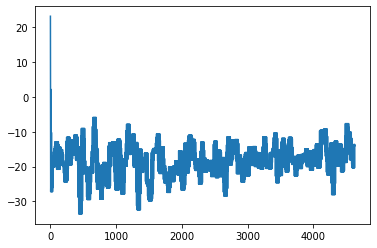

In [17]:
import matplotlib.pyplot as plt
plt.plot(np.arange(array.shape[0]),array*8)

In [46]:
len(train_dataset)

329762

In [45]:
from scipy.stats import pearsonr
pc, pred, targ, loss = pearsonr_eval(model, validation_data, 5, device)

In [46]:
pc

0.5002734320792447

In [47]:
loss

tensor(-2.4816, device='cuda:1', dtype=torch.float64)

In [13]:
train_dataset = ValidationDataset(data_path)
validation_data =  DataLoader(train_dataset, batch_size=1)

In [16]:
for reset_int in [200, 300, 400, 500, 600 ,700, 800, 900, 1000, 1100, 1200]:
    pc, pred, targ, loss = pearsonr_eval_reset(model, validation_data, reset_int, len(train_dataset), 5, device)
    print(reset_int, pc, loss)

200 nan tensor(0.7796, device='cuda:2', dtype=torch.float64)


KeyboardInterrupt: 

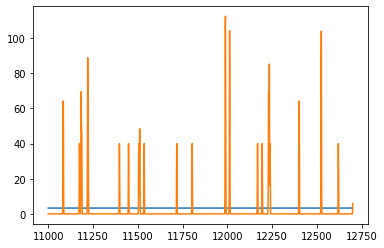

In [17]:
import matplotlib.pyplot as plt
plt.plot(np.arange(11000,12700),pred[11000:12700,3])
plt.plot(np.arange(11000,12700),targ[11000:12700,3])

In [90]:
for reset_int in [2000, 3000, 5000, 8000, 15000, 30000]:
    pc, pred, targ, loss = pearsonr_eval_reset(model, validation_data, reset_int, len(train_dataset), 5, device)
    print(reset_int, pc, loss)

2000 0.30764125334432935 tensor(-0.5165, device='cuda:1', dtype=torch.float64)
3000 0.27221796163831824 tensor(-0.2303, device='cuda:1', dtype=torch.float64)
5000 0.23917959420723234 tensor(0.0754, device='cuda:1', dtype=torch.float64)
8000 0.24719217762501033 tensor(0.2233, device='cuda:1', dtype=torch.float64)
15000 0.25631904833254804 tensor(0.2978, device='cuda:1', dtype=torch.float64)
30000 0.2555771892396666 tensor(0.3986, device='cuda:1', dtype=torch.float64)


In [24]:
pc, pred, targ, loss = pearsonr_eval_reset(model, validation_data, 600, len(train_dataset), 5, device)
print(pc, loss)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 10368])

In [16]:
pearsonr_eval_printh(model, validation_data, 5, 300, device)

0 tensor(0., device='cuda:2') tensor(0.9999, device='cuda:2')
300 tensor(2.8282e-12, device='cuda:2') tensor(0.8544, device='cuda:2')
600 tensor(2.1633e-11, device='cuda:2') tensor(0.9501, device='cuda:2')
900 tensor(6.9618e-11, device='cuda:2') tensor(0.9909, device='cuda:2')
1200 tensor(1.5739e-10, device='cuda:2') tensor(0.9953, device='cuda:2')
1500 tensor(2.9267e-10, device='cuda:2') tensor(0.9969, device='cuda:2')
1800 tensor(4.8166e-10, device='cuda:2') tensor(0.9971, device='cuda:2')
2100 tensor(7.2897e-10, device='cuda:2') tensor(0.9969, device='cuda:2')
2400 tensor(1.0379e-09, device='cuda:2') tensor(0.9964, device='cuda:2')
2700 tensor(1.4109e-09, device='cuda:2') tensor(0.9960, device='cuda:2')
3000 tensor(1.8497e-09, device='cuda:2') tensor(0.9955, device='cuda:2')
3300 tensor(2.3555e-09, device='cuda:2') tensor(0.9951, device='cuda:2')
3600 tensor(2.9293e-09, device='cuda:2') tensor(0.9946, device='cuda:2')
3900 tensor(3.5716e-09, device='cuda:2') tensor(0.9942, device='c

NameError: name 'pearsonr' is not defined

In [84]:
pc

0.013219606880046444

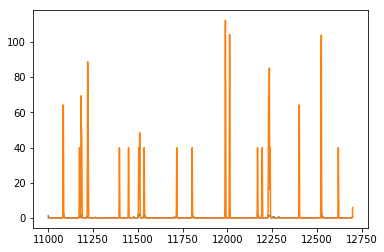

In [40]:
import matplotlib.pyplot as plt
plt.plot(np.arange(11000,12700),pred[11000:12700,3])
plt.plot(np.arange(11000,12700),targ[11000:12700,3])

In [91]:
for key in checkpoint['model_state_dict'].keys():
    if 'kinetics' in key:
        print(key, checkpoint['model_state_dict'][key])

kinetics.ka tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:1')
kinetics.kfi tensor([[ 0.1125],
        [ 0.4351],
        [ 0.4564],
        [ 0.5229],
        [ 0.2143],
        [-0.4878],
        [ 0.1650],
        [ 0.4262]], device='cuda:1')
kinetics.kfr tensor([[-0.5986],
        [-0.6079],
        [ 0.7536],
        [ 0.9314],
        [-0.8912],
        [ 0.3979],
        [-0.9637],
        [ 0.6206]], device='cuda:1')
kinetics.ksi tensor([[-4.3104e-04],
        [ 3.3938e-05],
        [-2.3214e-04],
        [ 1.7837e-06],
        [-2.1479e-04],
        [-5.8240e-04],
        [-4.5942e-04],
        [ 5.8508e-05]], device='cuda:1')
kinetics.ksr tensor([[ 5.4872e-07],
        [ 2.3322e-07],
        [-2.6707e-08],
        [ 2.2848e-07],
        [-5.1399e-07],
        [ 2.6111e-06],
        [-1.5864e-08],
        [ 1.6821e-08]], device='cuda:1')


In [37]:
checkpoint['model_state_dict'].keys()

odict_keys(['bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'bipolar.2.weight', 'bipolar.2.bias', 'bipolar.5.multiplier', 'kinetics.ka', 'kinetics.kfi', 'kinetics.kfr', 'kinetics.ksi', 'kinetics.ksr', 'kinet_scale.scale_param', 'kinet_scale.shift_param', 'amacrine.1.convs.0.weight', 'amacrine.1.convs.1.weight', 'amacrine.1.convs.2.weight', 'amacrine.1.convs.3.weight', 'amacrine.1.convs.4.weight', 'amacrine.1.convs.4.bias', 'amacrine.3.weight', 'amacrine.3.bias', 'ganglion.0.weight', 'ganglion.0.bias', 'ganglion.1.weight', 'ganglion.1.bias'])

In [43]:
checkpoint['model_state_dict']['amacrine.3.bias']

tensor([-3.5569e-04, -1.2885e-13, -3.9355e-03,  ...,  5.8120e-02,
         7.9140e-02,  3.7187e-02], device='cuda:0')

In [49]:
pred[11000:11100,3]

array([ 1.348986  ,  1.4387271 ,  1.5289254 ,  1.6403759 ,  1.7801998 ,
        1.931041  ,  2.06931   ,  2.1698706 ,  2.2228231 ,  2.2493289 ,
        2.2093933 ,  2.1253173 ,  2.003521  ,  1.8392639 ,  1.6101074 ,
        1.2906842 ,  1.0333914 ,  0.8218001 ,  0.6648578 ,  0.6494985 ,
        0.69522697,  0.80693376,  0.99657655,  1.2136891 ,  1.4331626 ,
        1.564425  ,  1.519738  ,  1.4605511 ,  1.4233972 ,  1.3934128 ,
        1.3643755 ,  1.4039971 ,  1.4658694 ,  1.5167211 ,  1.3853804 ,
        1.1601368 ,  0.95271003,  0.8729989 ,  1.1541355 ,  2.1227472 ,
        4.046956  ,  6.966586  , 10.09161   , 12.777767  , 14.572852  ,
       15.041913  , 14.714552  , 13.488459  , 11.762767  ,  9.585559  ,
        7.9264317 ,  6.866749  ,  6.4408035 ,  5.993018  ,  5.6431293 ,
        5.1263437 ,  4.6907825 ,  3.9479897 ,  3.092077  ,  2.2794445 ,
        1.7888294 ,  1.7335874 ,  2.0521245 ,  2.6588929 ,  3.636105  ,
        4.4381022 ,  4.935599  ,  5.096521  ,  5.180359  ,  5.30

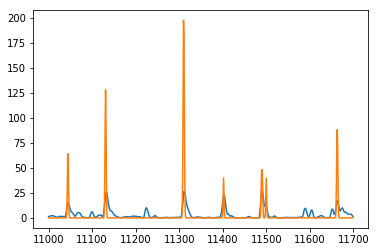

In [55]:
import matplotlib.pyplot as plt
plt.plot(np.arange(11000,11700),pred[11000:11700,3])
plt.plot(np.arange(11000,11700),targ[11000:11700,3])

In [50]:
targ[11000:11100,3]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.48672163e-04,
       1.35832712e-02, 4.59183041e-01, 5.87606360e+00, 2.97204717e+01,
       6.41839805e+01, 6.39513574e+01, 2.93843360e+01, 5.75986672e+00,
       4.45991405e-01, 1.29273006e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [44]:
def eval_loss(pred, targ, device):
    batch_size = 512
    loss_fn = nn.PoissonNLLLoss(log_input=False, reduction='sum').to(device)
    loss = 0
    n_batch = pred.shape[0] // batch_size
    pred = torch.from_numpy(pred)
    targ = torch.from_numpy(targ)
    with torch.no_grad():
        for idx in range(n_batch):
            loss += loss_fn(pred[batch_size*idx:batch_size*(idx+1)].to(device), 
                            targ[batch_size*idx:batch_size*(idx+1)].to(device))
    loss /= pred.shape[0]
    return loss

In [45]:
import torch.nn as nn
eval_loss(pred, targ, device)

tensor(-10.3883, device='cuda:0', dtype=torch.float64)

In [33]:
pred.shape

(30000, 5)

In [3]:
import sys
sys.path.insert(0, './fnn')
from fnn.models import BNCNN_3D2_Stack
from fnn.evaluation import pearsonr_eval
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import torch
device = torch.device('cuda:1')
model = BNCNN_3D2_Stack().to(device)
checkpoint_path = '/home/xhding/saved_model/3d_conv2_stack/epoch_045_loss_-5.25_pearson_0.4373_eval_loss_0.92.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

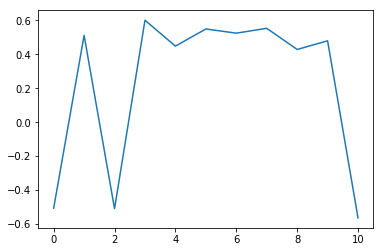

In [4]:
import matplotlib.pyplot as plt
import numpy as np
filter_w = checkpoint['model_state_dict']['ganglion.1.filter'].cpu().numpy().squeeze()
plt.plot(np.arange(filter_w.shape[0]), filter_w)

In [5]:
def pearsonr_batch_eval(model, data, n_units, device):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        pearsons = []
        val_pred = []
        val_targ = []
        for x,y in data:
            x = x.to(device)
            out = model(x)
            val_pred.append(out.detach().cpu().numpy())
            val_targ.append(y.detach().numpy())
        val_pred = np.concatenate(val_pred, axis=0)
        val_targ = np.concatenate(val_targ, axis=0)
        for cell in range(n_units):
            pearsons.append(pearsonr(val_pred[:,cell],val_targ[:,cell])[0])
        model.train()
        return np.array(pearsons).mean(), val_pred, val_targ

In [7]:
def pearsonr_batch_eval_cut_tail(model, data, n_units, device):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        pearsons = []
        val_pred = []
        val_targ = []
        for x,y in data:
            x[:, 0:-40] = 0.
            x = x.to(device)
            out = model(x)
            val_pred.append(out.detach().cpu().numpy())
            val_targ.append(y.detach().numpy())
        val_pred = np.concatenate(val_pred, axis=0)
        val_targ = np.concatenate(val_targ, axis=0)
        for cell in range(n_units):
            pearsons.append(pearsonr(val_pred[:,cell],val_targ[:,cell])[0])
        model.train()
        return np.array(pearsons).mean()

In [13]:
from scipy.stats import pearsonr
pc, pred, targ = pearsonr_batch_eval(model, validation_data, 5, device)
pc

0.4372953595290882

In [14]:
pc = pearsonr_batch_eval_cut_tail(model, validation_data, 5, device)
pc

0.4510679944842133

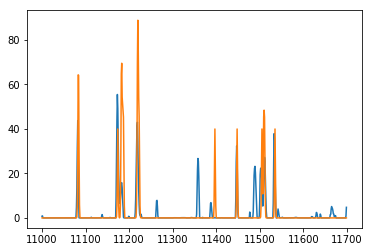

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.arange(11000,11700),pred[11000:11700,3])
plt.plot(np.arange(11000,11700),targ[11000:11700,3])

In [2]:
import sys
sys.path.insert(0, './fnn')
from fnn.models import BN_CNN_Stack
from fnn.evaluation import pearsonr_eval
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import torch
device = torch.device('cuda:3')
model = BN_CNN_Stack().to(device)
checkpoint_path = '/home/grantsrb/gcchanssim14.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)

In [34]:
checkpoint['model_state_dict'].keys()

odict_keys(['sequential.0.convs.0.weight', 'sequential.0.convs.2.weight', 'sequential.0.convs.4.weight', 'sequential.0.convs.6.weight', 'sequential.0.convs.8.weight', 'sequential.0.convs.10.weight', 'sequential.0.convs.12.weight', 'sequential.0.convs.12.bias', 'sequential.1.running_mean', 'sequential.1.running_var', 'sequential.1.scale', 'sequential.1.shift', 'sequential.2.sigma', 'sequential.4.convs.0.weight', 'sequential.4.convs.2.weight', 'sequential.4.convs.4.weight', 'sequential.4.convs.6.weight', 'sequential.4.convs.8.weight', 'sequential.4.convs.8.bias', 'sequential.5.running_mean', 'sequential.5.running_var', 'sequential.5.scale', 'sequential.5.shift', 'sequential.7.sigma', 'sequential.10.weight', 'sequential.12.running_mean', 'sequential.12.running_var', 'sequential.12.scale', 'sequential.12.shift'])

In [3]:
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_030_loss_-2.77_pearson_0.6291_eval_loss_-29.18.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
checkpoint['model_state_dict'].keys()

odict_keys(['bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'bipolar.2.weight', 'bipolar.2.bias', 'bipolar.2.running_mean', 'bipolar.2.running_var', 'bipolar.2.num_batches_tracked', 'bipolar.3.sigma', 'amacrine.1.convs.0.weight', 'amacrine.1.convs.1.weight', 'amacrine.1.convs.2.weight', 'amacrine.1.convs.3.weight', 'amacrine.1.convs.4.weight', 'amacrine.1.convs.4.bias', 'amacrine.3.weight', 'amacrine.3.bias', 'amacrine.3.running_mean', 'amacrine.3.running_var', 'amacrine.3.num_batches_tracked', 'amacrine.4.sigma', 'ganglion.0.weight', 'ganglion.1.weight', 'ganglion.1.bias', 'ganglion.1.running_mean', 'ganglion.1.running_var', 'ganglion.1.num_batches_tracked'])

In [17]:
class TestDataset(Dataset):
    
    def __init__(self, data_path):
        super().__init__()
        data = loadexpt('15-10-07', [0,1,2,3,4], 'naturalscene', 'test',
                        40, 0, data_path=data_path)
        self.X = data.X[:]
        self.y = data.y[:]
        self.centers = data.centers
        self.stats = data.stats
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        inpt = torch.from_numpy(self.X[index])
        trgt = torch.from_numpy(self.y[index])
        return (inpt, trgt)

In [19]:
test_data = DataLoader(TestDataset(data_path), batch_size=512)

In [4]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [20]:
from scipy.stats import pearsonr
pc, pred, targ = pearsonr_batch_eval(model, test_data, 5, device)
pc

0.7377298532562697

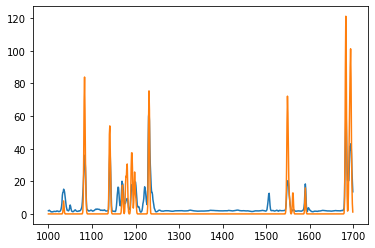

In [25]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1000,1700),4*pred[1000:1700,3])
plt.plot(np.arange(1000,1700),targ[1000:1700,3])

In [1]:
import matplotlib.pyplot as plt

(0, 1)

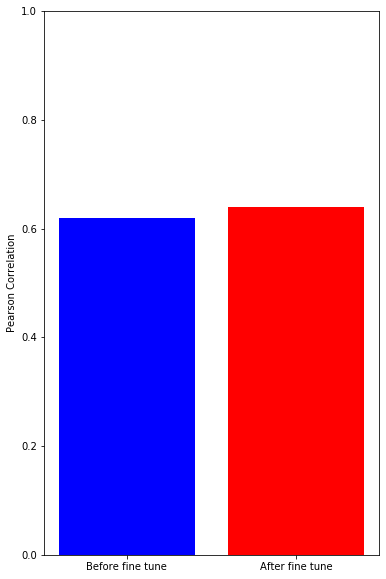

In [14]:
fig, ax = plt.subplots(figsize=(6,10))
rects1 = ax.bar(['Before fine tune', 'After fine tune'], [0.62, 0.64], color=['blue', 'red'])
ax.set_ylabel('Pearson Correlation')
ax.set_ylim([0, 1])

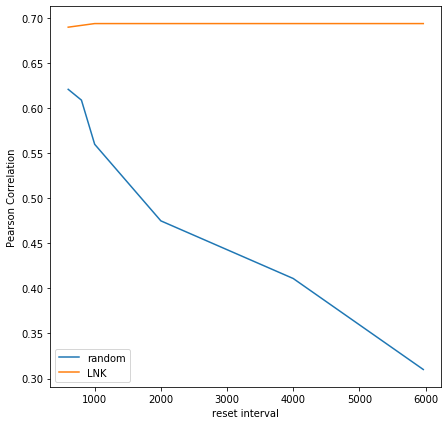

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
ax.set_ylabel('Pearson Correlation')
ax.set_xlabel('reset interval')
plt.plot([600, 800, 1000, 2000, 4000, 5965],[0.621,0.609,0.560,0.475, 0.411, 0.31], label='random')
plt.plot([600, 800, 1000, 2000, 4000, 5965],[0.69, 0.692,0.694,0.694,0.694, 0.694], label='LNK')
plt.legend()